<a href="https://colab.research.google.com/github/ahliminha/contrastive_learning_for_medical_images/blob/main/Estudo_de_imagens_m%C3%A9dicas_e_classifica%C3%A7%C3%A3o_dos_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo sobre imagens médicas de Raios-X em pacientes saudáveis e diagnosticados com Covid-19

## Preparação do ambiente

https://stackoverflow.com/questions/60798910/google-colab-pro-gpu-running-extremely-slow

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
!pip install piq

     |████████████████████████████████| 127 kB 5.3 MB/s 


In [ ]:
! pip install gdown

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import gdown

tf.config.run_functions_eagerly(True)
np.random.seed(0)

In [ ]:
! gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
100% 780M/780M [00:07<00:00, 110MB/s]


In [ ]:
! mkdir dataset 
! unzip COVID-19_Radiography_Database.zip -d dataset

In [ ]:
! rm -r '/content/dataset/COVID-19_Radiography_Dataset/Lung_Opacity'

In [ ]:
! rm -r '/content/dataset/COVID-19_Radiography_Dataset/Viral Pneumonia'

## Preparação do dataset

In [ ]:
train_data_dir = "/content/dataset/COVID-19_Radiography_Dataset"

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [ ]:
img_height, img_width=64,64
input_shape = (img_width, img_width, 3)
batch_size = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='int')

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='int')


Found 13808 files belonging to 2 classes.
Using 9666 files for training.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Found 13808 files belonging to 2 classes.
Using 4142 files for validation.


In [ ]:
@tf.function
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    x = x.numpy()
    y = y.numpy()
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
print(train_ds)

<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>


In [ ]:
@tf.function
def process_data(data):
  """
    data: Tensorflow dataset.
  """
  pairs = []
  labels = []

  for x, y in data:
    x_transformed, y_transformed = make_pairs(x, y)
    pairs.append(x_transformed)
    labels.append(y_transformed)
  
  return (np.concatenate(pairs, axis=0), np.concatenate(labels, axis=0))

In [ ]:
pairs_train, labels_train = process_data(train_ds)

In [ ]:
pairs_val, labels_val = process_data(val_ds)

https://keras.io/examples/vision/siamese_contrastive/

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(15, 15))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1).numpy().astype('uint8'), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


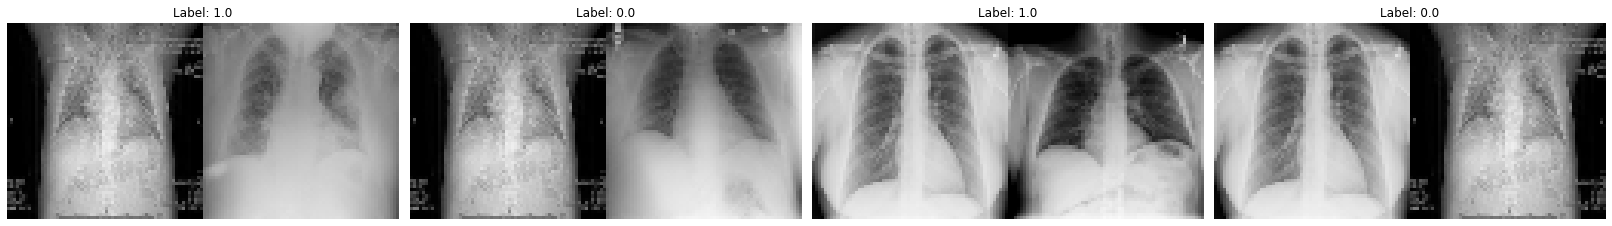

In [ ]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input(input_shape)
#x = tf.keras.layers.BatchNormalization()(input)
#x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
#x = layers.AveragePooling2D(pool_size=(2, 2))(x)
#x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
#x = layers.AveragePooling2D(pool_size=(2, 2))(x)
#x = layers.Flatten()(x)
#
#x = tf.keras.layers.BatchNormalization()(x)
#x = layers.Dense(10, activation="tanh")(x)
#embedding_network = tf.keras.Model(input, x)

resnet = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=input_shape, pooling="avg")

input_1 = layers.Input(input_shape)
input_2 = layers.Input(input_shape)

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = resnet(input_1)
tower_2 = resnet(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [ ]:
siamese.compile(loss=loss(), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 1280)         4049571     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           efficientnetb0[0][0]         

In [ ]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]

## Treino da rede

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=2,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/2
194/194 [==============================] - 195s 996ms/step - loss: 0.1461 - accuracy: 0.8098 - val_loss: 0.1076 - val_accuracy: 0.8761
Epoch 2/2
194/194 [==============================] - 193s 994ms/step - loss: 0.0392 - accuracy: 0.9777 - val_loss: 0.0476 - val_accuracy: 0.9404


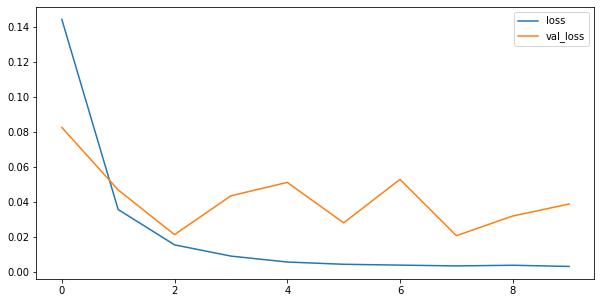

In [ ]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()

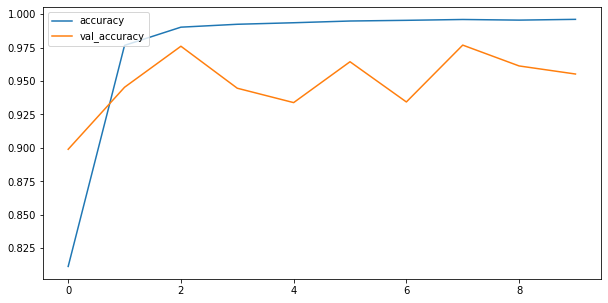

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')



## Import da rede - Para não treinar de novo

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Estagio/Modelos/model_efficientnet_contrastive_imagenet_10_epochs_30_val.h5', custom_objects={'contrastive_loss': loss()})

## Teste da rede

In [ ]:
predictions = siamese.predict([x_val_1, x_val_2])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
predictions

array([[0.88092923],
       [0.09146516],
       [0.9153119 ],
       ...,
       [0.08511668],
       [0.9008294 ],
       [0.04929478]], dtype=float32)

In [ ]:
binary_predictions = (predictions>0.5).astype(np.int_) 
print(binary_predictions)

[[1]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


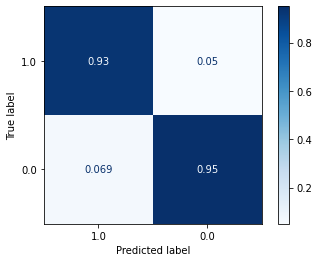

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_val, binary_predictions)
cm_normed = cm / cm.sum(axis=0)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normed, display_labels=labels_val)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(cm)

[[3941  201]
 [ 293 3849]]


In [ ]:
siamese.save('model_efficientnet_contrastive_imagenet_2_epochs_30_val.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
siamese.save_weights('model_efficientnet_contrastive_imagenet_2_epochs_30_val_w.h5')


## Extração de métricas
Visualização de dados com heatmap (GradCAM): https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759 
https://keras.io/examples/vision/grad_cam/ 
Visualização dos filtros: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/ 

Ideia:
Calcular BRISQUE pra todas as imagens de validação (image-quality package)
Calcular SSIM pros pares (tf.image.ssim)

Iterar sobre as predições e as labels verdadeiras para separar quais são de cada quadrante da CM. 

Analisar os dados das métricas e inferir sobre.

In [ ]:
import piq
import torch

In [ ]:
images_description_list = []
images_description = {}

for i in range(len(labels_val)):
  if labels_val[i] == 1.0 and  binary_predictions[i] == 1.0:
    CM_label = 'TP'
  elif labels_val[i] == 1.0 and  binary_predictions[i] == 0.0:
    CM_label = 'FN'
  elif labels_val[i] == 0.0 and  binary_predictions[i] == 1.0:
    CM_label = 'FP'
  elif labels_val[i] == 0.0 and  binary_predictions[i] == 0.0:
    CM_label = 'TN'
  x = torch.tensor(x_val_1[i]).permute(2, 0, 1)[None, ...] / 255.
  y = torch.tensor(x_val_2[i]).permute(2, 0, 1)[None, ...] / 255.
  
  if torch.cuda.is_available():
      # Move to GPU to make computaions faster
      x = x.cuda()
      y = y.cuda()

  images_description = {
    'label_X': labels_val[i], 
    'BRISQUE_X': piq.brisque(x, data_range=1., reduction='none').item(),
    'label_Y': binary_predictions[i],
    'BRISQUE_Y': piq.brisque(y, data_range=1., reduction='none').item(),
    'SSIM': piq.ssim(x, y, data_range=1.).item(),
    'FSIM': piq.fsim(x, y, data_range=1., reduction='none').item(),
    'TV_X': piq.total_variation(x).item(),
    'TV_Y': piq.total_variation(y).item(),
    'CM label': CM_label
  }
  images_description_list.append(images_description)


In [ ]:
images_description_df = pd.DataFrame(images_description_list)

In [ ]:
images_description_df['label_Y'] = images_description_df['label_Y'].str.get(0)

In [ ]:
images_description_df.head()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y,CM label
0,1.0,34.826355,1,49.566589,0.330910,0.671534,10.163298,11.821282,TP
1,0.0,34.826355,0,35.630066,0.228216,0.690047,10.163298,4.711935,TN
2,1.0,40.387390,1,28.567078,0.396207,0.656158,9.878390,5.136484,TP
3,0.0,40.387390,0,35.630066,0.366917,0.696202,9.878390,4.711935,TN
4,1.0,33.280945,1,26.671082,0.445643,0.752524,4.624321,8.369758,TP


In [ ]:
images_description_df.to_csv('images_data.csv')

In [ ]:
images_description_df.describe()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y
count,8284.00000,8284.000000,8284.000000,8284.000000,8284.000000,8284.000000,8284.000000,8284.000000
mean,0.50000,34.727320,0.488894,34.147715,0.307470,0.671442,10.140192,9.716066
std,0.50003,12.031022,0.499907,11.823455,0.125632,0.061878,2.639977,2.756280
min,0.00000,-1.077454,0.000000,-0.988586,-0.149811,0.420236,2.049486,2.049486
25%,0.00000,26.463562,0.000000,26.147400,0.226964,0.635599,8.311966,7.757819
50%,0.50000,33.331238,0.000000,33.113220,0.299611,0.671943,10.087307,9.544283
75%,1.00000,41.688660,1.000000,40.892761,0.376892,0.706029,11.844838,11.506302
max,1.00000,92.647400,1.000000,92.647400,1.000000,1.000000,24.756016,20.464390


## Estudo das métricas

In [ ]:
FROM_DRIVE = False
if FROM_DRIVE:
  images_description_df = pd.read_csv('/content/drive/MyDrive/Estagio/images_data.csv')

In [ ]:
images_description_df.head()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y,CM label
0,1.0,34.826355,1,49.566589,0.330910,0.671534,10.163298,11.821282,TP
1,0.0,34.826355,0,35.630066,0.228216,0.690047,10.163298,4.711935,TN
2,1.0,40.387390,1,28.567078,0.396207,0.656158,9.878390,5.136484,TP
3,0.0,40.387390,0,35.630066,0.366917,0.696202,9.878390,4.711935,TN
4,1.0,33.280945,1,26.671082,0.445643,0.752524,4.624321,8.369758,TP


In [ ]:
images_description_df.describe()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y
count,8284.00000,8284.000000,8284.000000,8284.000000,8284.000000,8284.000000,8284.000000,8284.000000
mean,0.50000,34.727320,0.488894,34.147715,0.307470,0.671442,10.140192,9.716066
std,0.50003,12.031022,0.499907,11.823455,0.125632,0.061878,2.639977,2.756280
min,0.00000,-1.077454,0.000000,-0.988586,-0.149811,0.420236,2.049486,2.049486
25%,0.00000,26.463562,0.000000,26.147400,0.226964,0.635599,8.311966,7.757819
50%,0.50000,33.331238,0.000000,33.113220,0.299611,0.671943,10.087307,9.544283
75%,1.00000,41.688660,1.000000,40.892761,0.376892,0.706029,11.844838,11.506302
max,1.00000,92.647400,1.000000,92.647400,1.000000,1.000000,24.756016,20.464390


In [ ]:
images_description_df.shape

(8284, 9)

In [ ]:
TP = images_description_df.loc[images_description_df['CM label'] == 'TP']
TP.describe()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y
count,3849.0,3849.000000,3849.0,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000
mean,1.0,34.841791,1.0,34.873888,0.323129,0.680100,10.130968,10.154046
std,0.0,12.044938,0.0,11.970360,0.142437,0.068698,2.635930,2.620271
min,1.0,-1.077454,1.0,-0.988586,-0.029265,0.431901,2.049486,2.049486
25%,1.0,26.524109,1.0,26.596375,0.236899,0.641530,8.323753,8.310276
50%,1.0,33.448914,1.0,33.479187,0.308169,0.676119,10.100497,10.140539
75%,1.0,41.888367,1.0,42.095886,0.389547,0.710973,11.815547,11.894830
max,1.0,92.647400,1.0,92.647400,1.000000,1.000000,22.580667,20.464390


In [ ]:
FP = images_description_df.loc[images_description_df['CM label'] == 'FP']
FP.describe()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y
count,201.0,201.000000,201.0,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.0,31.298077,1.0,33.034858,0.310874,0.678282,9.637990,9.319053
std,0.0,11.020483,0.0,12.002350,0.106640,0.053799,2.851383,2.830595
min,0.0,-0.988586,1.0,-0.988586,-0.053600,0.513914,4.511989,2.152491
25%,0.0,24.559753,1.0,25.268250,0.235056,0.651680,7.668378,7.422437
50%,0.0,29.683777,1.0,31.106628,0.310156,0.683341,8.959122,8.601164
75%,0.0,37.417664,1.0,39.184753,0.379216,0.712941,11.311502,10.603802
max,0.0,79.518005,1.0,88.114685,0.581693,0.811216,24.756016,19.492075


In [ ]:
TN = images_description_df.loc[images_description_df['CM label'] == 'TN']
TN.describe()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y
count,3941.0,3941.000000,3941.0,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000
mean,0.0,34.902219,0.0,33.415356,0.292806,0.662913,10.165805,9.255131
std,0.0,12.056224,0.0,11.528814,0.106764,0.054212,2.626724,2.808390
min,0.0,-1.077454,0.0,1.191589,-0.095453,0.443967,2.049486,2.049486
25%,0.0,26.547546,0.0,25.806335,0.221280,0.628995,8.366670,7.341035
50%,0.0,33.482605,0.0,32.461609,0.290427,0.666907,10.126726,8.790467
75%,0.0,41.902039,0.0,39.905945,0.365411,0.700815,11.858230,10.822242
max,0.0,92.647400,0.0,92.647400,0.622514,0.836439,22.580667,20.464390


In [ ]:
FN = images_description_df.loc[images_description_df['CM label'] == 'FN']
FN.describe()

,label_X,BRISQUE_X,label_Y,BRISQUE_Y,SSIM,FSIM,TV_X,TV_Y
count,293.0,293.000000,293.0,293.000000,293.000000,293.000000,293.000000,293.000000
mean,1.0,33.223575,0.0,35.222355,0.296670,0.667720,10.261363,10.434679
std,0.0,11.774214,0.0,12.995654,0.111816,0.052582,2.696439,2.663082
min,1.0,-0.988586,0.0,-0.988586,-0.149811,0.420236,3.997383,3.997383
25%,1.0,26.042175,0.0,26.750183,0.213644,0.636148,8.242240,8.594880
50%,1.0,31.848816,0.0,33.363464,0.299480,0.668024,9.953192,10.459428
75%,1.0,38.371277,0.0,41.912781,0.374975,0.704699,12.082197,12.325704
max,1.0,79.518005,0.0,79.518005,0.556466,0.819415,24.756016,17.310360
